# Vision-Language-Audio Perception System for Assistive Navigation

**Author:** Aayush Khanal  
**Student ID:** 20049123

## Abstract
This project implements a multi-modal AI system designed to assist visually impaired individuals with navigation. The system integrates object detection (YOLOv8), scene captioning (BLIP-2), optical character recognition (TrOCR), and text-to-speech synthesis to provide real-time audio feedback about the surrounding environment.

## System Components
1. **Object Detection:** YOLOv8 fine-tuned on COCO and Road Sign datasets
2. **Scene Captioning:** BLIP-2 for generating visual descriptions
3. **Text Recognition:** TrOCR for reading signs and labels
4. **Audio Output:** Text-to-Speech for real-time feedback

## Pipeline Overview
1. Filter COCO dataset to assistive-relevant classes
2. Merge with Road Sign dataset for unified training
3. Train YOLOv8 object detector
4. Fuse detections with OCR and captions
5. Generate audio descriptions for navigation assistance

In [ ]:
# Environment Setup and Imports

import os
import gc
import json
import shutil
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import xml.etree.ElementTree as ET
from collections import Counter
import warnings
from tqdm.auto import tqdm
from pathlib import Path
import torch
import torch.cuda as cuda

warnings.filterwarnings('ignore')
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

def setup_kaggle_environment():
    """Configure optimal settings for Kaggle GPU environment."""
    print("=" * 60)
    print("Environment Configuration")
    print("=" * 60)
    
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"GPU: {gpu_name} ({gpu_memory:.2f} GB)")
        
        if gpu_memory >= 15:
            optimal_batch, optimal_workers = 32, 8
        elif gpu_memory >= 10:
            optimal_batch, optimal_workers = 16, 4
        else:
            optimal_batch, optimal_workers = 8, 2
            
        if torch.cuda.get_device_capability()[0] >= 8:
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
        
        torch.backends.cudnn.benchmark = True
        return optimal_batch, optimal_workers
    else:
        print("No GPU detected - using CPU")
        return 4, 2

BATCH_SIZE, NUM_WORKERS = setup_kaggle_environment()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")
print("=" * 60)

KAGGLE ENVIRONMENT SETUP
GPU Available: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB
Recommended Batch Size: 32
Recommended Workers: 8
cuDNN Benchmark Enabled

Device: cuda


In [ ]:
# Install Required Packages

!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install -q ultralytics
!pip install -q transformers accelerate evaluate sentencepiece
!pip install -q gtts==2.4.0 pyttsx3 jiwer
!pip install -q pycocoevalcap

print("All packages installed successfully.")

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 66.3 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.2 which is incompatible.
gradio 5.49.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 18.7 MB/s eta 0:00:0000:0100:01
All packages installed successfully!


In [ ]:
# Data Paths and Loading

import os
import json

COCO_PATH = "/kaggle/input/coco-2014-dataset-for-yolov3/coco2014"
ROAD_SIGN_PATH = "/kaggle/input/road-sign-detection"
COCO_CAPTION_PATH = "/kaggle/input/coco-image-caption"

# Determine COCO dataset location
if os.path.exists(COCO_PATH):
    COCO_IMAGES_TRAIN = os.path.join(COCO_PATH, "images/train2014")
    COCO_IMAGES_VAL = os.path.join(COCO_PATH, "images/val2014")
    COCO_INSTANCES_TRAIN = os.path.join(COCO_PATH, "annotations/instances_train2014.json")
    COCO_INSTANCES_VAL = os.path.join(COCO_PATH, "annotations/instances_val2014.json")
    COCO_CAPTIONS_TRAIN = os.path.join(COCO_PATH, "annotations/captions_train2014.json")
    COCO_CAPTIONS_VAL = os.path.join(COCO_PATH, "annotations/captions_val2014.json")
    print(f"Using COCO 2014 dataset from: {COCO_PATH}")

elif os.path.exists(COCO_CAPTION_PATH):
    COCO_IMAGES_TRAIN = os.path.join(COCO_CAPTION_PATH, "train2014/train2014")
    val2014_path = os.path.join(COCO_CAPTION_PATH, "val2014/val2014")
    val2017_path = os.path.join(COCO_CAPTION_PATH, "val2017/val2017")

    if os.path.exists(val2014_path):
        COCO_IMAGES_VAL = val2014_path
    elif os.path.exists(val2017_path):
        COCO_IMAGES_VAL = val2017_path
    else:
        raise FileNotFoundError("No valid COCO validation images found.")

    COCO_INSTANCES_TRAIN = os.path.join(COCO_CAPTION_PATH, "annotations_trainval2014/annotations/instances_train2014.json")
    COCO_INSTANCES_VAL = os.path.join(COCO_CAPTION_PATH, "annotations_trainval2014/annotations/instances_val2014.json")
    COCO_CAPTIONS_TRAIN = os.path.join(COCO_CAPTION_PATH, "annotations_trainval2014/annotations/captions_train2014.json")
    COCO_CAPTIONS_VAL = os.path.join(COCO_CAPTION_PATH, "annotations_trainval2014/annotations/captions_val2014.json")
    print(f"Using COCO Caption dataset from: {COCO_CAPTION_PATH}")
else:
    raise FileNotFoundError("COCO dataset not found!")

# Verify paths
paths = {
    "COCO_IMAGES_TRAIN": COCO_IMAGES_TRAIN,
    "COCO_IMAGES_VAL": COCO_IMAGES_VAL,
    "COCO_INSTANCES_TRAIN": COCO_INSTANCES_TRAIN,
    "COCO_INSTANCES_VAL": COCO_INSTANCES_VAL,
    "COCO_CAPTIONS_TRAIN": COCO_CAPTIONS_TRAIN,
    "COCO_CAPTIONS_VAL": COCO_CAPTIONS_VAL,
    "ROAD_SIGN_PATH": ROAD_SIGN_PATH,
}

for name, p in paths.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing path: {name} -> {p}")

# Load JSON annotations
print("\nLoading COCO Annotations...")

with open(COCO_INSTANCES_TRAIN, 'r') as f:
    coco_instances_train = json.load(f)
print(f"Train instances: {len(coco_instances_train['annotations']):,}")

with open(COCO_INSTANCES_VAL, 'r') as f:
    coco_instances_val = json.load(f)
print(f"Val instances: {len(coco_instances_val['annotations']):,}")

with open(COCO_CAPTIONS_TRAIN, 'r') as f:
    coco_captions_train = json.load(f)
print(f"Train captions: {len(coco_captions_train['annotations']):,}")

with open(COCO_CAPTIONS_VAL, 'r') as f:
    coco_captions_val = json.load(f)
print(f"Val captions: {len(coco_captions_val['annotations']):,}")

coco_instances = coco_instances_train
print("\nCOCO annotations loaded successfully.")

Using COCO Caption dataset from: /kaggle/input/coco-image-caption

Verifying COCO paths...
   ✅ COCO_IMAGES_TRAIN exists
   ✅ COCO_IMAGES_VAL exists
   ✅ COCO_INSTANCES_TRAIN exists
   ✅ COCO_INSTANCES_VAL exists
   ✅ COCO_CAPTIONS_TRAIN exists
   ✅ COCO_CAPTIONS_VAL exists
   ✅ ROAD_SIGN_PATH exists

Loading COCO Annotations...
Train instances: 604,907
Val instances: 291,875
Train captions: 414,113
Val captions: 202,654

COCO annotations loaded successfully!


In [ ]:
# Explore COCO Dataset Structure

print("COCO Dataset Structure")
print(f"Train Images: {len(coco_captions_train['images']):,}")
print(f"Val Images: {len(coco_captions_val['images']):,}")
print(f"Train Captions: {len(coco_captions_train['annotations']):,}")
print(f"Val Captions: {len(coco_captions_val['annotations']):,}")
print(f"Object Categories: {len(coco_instances['categories'])}")

COCO DATASET STRUCTURE

1. Caption Dataset Keys:
   Train: dict_keys(['info', 'images', 'licenses', 'annotations'])
   Val: dict_keys(['info', 'images', 'licenses', 'annotations'])

2. Number of Images:
   Train: 82,783
   Val: 40,504

3. Number of Captions:
   Train: 414,113
   Val: 202,654

4. Object Categories: {len(coco_instances['categories'])}


In [ ]:
# Create DataFrames for Analysis

coco_images_train_df = pd.DataFrame(coco_captions_train['images'])
coco_images_val_df = pd.DataFrame(coco_captions_val['images'])
coco_images = pd.concat([coco_images_train_df, coco_images_val_df], ignore_index=True)

coco_captions_train_df = pd.DataFrame(coco_captions_train['annotations'])
coco_captions_val_df = pd.DataFrame(coco_captions_val['annotations'])
coco_captions_df = pd.concat([coco_captions_train_df, coco_captions_val_df], ignore_index=True)

coco_instances_train_df = pd.DataFrame(coco_instances_train['annotations'])
coco_instances_val_df = pd.DataFrame(coco_instances_val['annotations'])
coco_objects = pd.concat([coco_instances_train_df, coco_instances_val_df], ignore_index=True)

coco_categories = pd.DataFrame(coco_instances_train['categories'])

print(f"Images: {coco_images.shape[0]:,}")
print(f"Captions: {coco_captions_df.shape[0]:,}")
print(f"Object Annotations: {coco_objects.shape[0]:,}")
print(f"Categories: {coco_categories.shape[0]}")

Creating COCO DataFrames
COCO Images: (123287, 8)
COCO Captions: (616767, 3)
COCO Categories: (80, 3)
COCO Objects: (896782, 7)


In [ ]:
# Caption Analysis

coco_captions_df['caption_length'] = coco_captions_df['caption'].str.split().str.len()

print("Caption Statistics:")
print(f"Mean Length: {coco_captions_df['caption_length'].mean():.2f} words")
print(f"Median Length: {coco_captions_df['caption_length'].median():.0f} words")
print(f"Range: {coco_captions_df['caption_length'].min()} - {coco_captions_df['caption_length'].max()} words")

captions_per_image = coco_captions_df.groupby('image_id').size()
print(f"Captions per Image: {captions_per_image.mean():.2f} avg")

COCO CAPTION ANALYSIS

1. Caption Length Statistics:
   Mean: 10.46 words
   Median: 10 words
   Min: 5, Max: 50

2. Captions per Image: 5.00 avg

3. Sample Captions:
   - Elephants are spraying water while standing in a river.
   - Some guys standing in a big hallway holding cell phones.
   - A young elephant huddles next to an adult elephant.


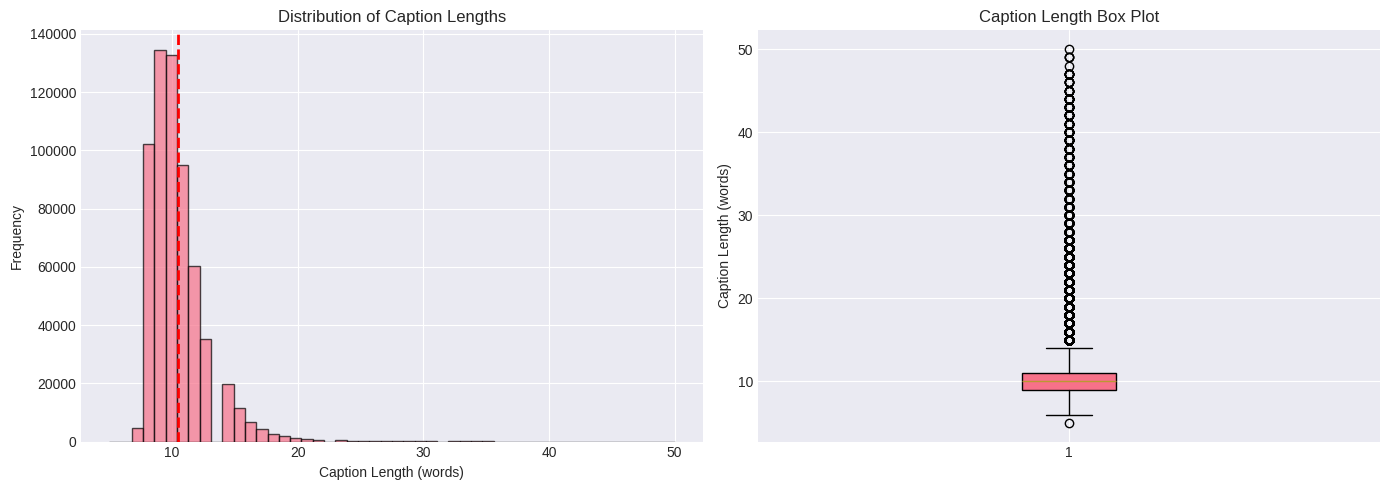

In [ ]:
# Caption Length Distribution

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(coco_captions_df['caption_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(coco_captions_df['caption_length'].mean(), color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Caption Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Caption Length Distribution')

axes[1].boxplot(coco_captions_df['caption_length'], vert=True, patch_artist=True)
axes[1].set_ylabel('Caption Length (words)')
axes[1].set_title('Caption Length Box Plot')

plt.tight_layout()
plt.show()

In [ ]:
# Image Dimensions Analysis

print("Image Dimensions:")
print(f"Average Width: {coco_images['width'].mean():.0f}px")
print(f"Average Height: {coco_images['height'].mean():.0f}px")

coco_images['aspect_ratio'] = coco_images['width'] / coco_images['height']
print(f"Mean Aspect Ratio: {coco_images['aspect_ratio'].mean():.2f}")

coco_images['size_category'] = pd.cut(
    coco_images['width'], 
    bins=[0, 640, 1280, 1920, 10000],
    labels=['Small (<640)', 'Medium (640-1280)', 'Large (1280-1920)', 'Very Large (>1920)']
)
print("\nSize Distribution:")
print(coco_images['size_category'].value_counts().sort_index())

IMAGE DIMENSIONS ANALYSIS

Resolution - Width: 578px avg, Height: 484px avg
Aspect Ratio - Mean: 1.25

Image Size Distribution:
size_category
Small (<640)          123287
Medium (640-1280)          0
Large (1280-1920)          0
Very Large (>1920)         0
Name: count, dtype: int64


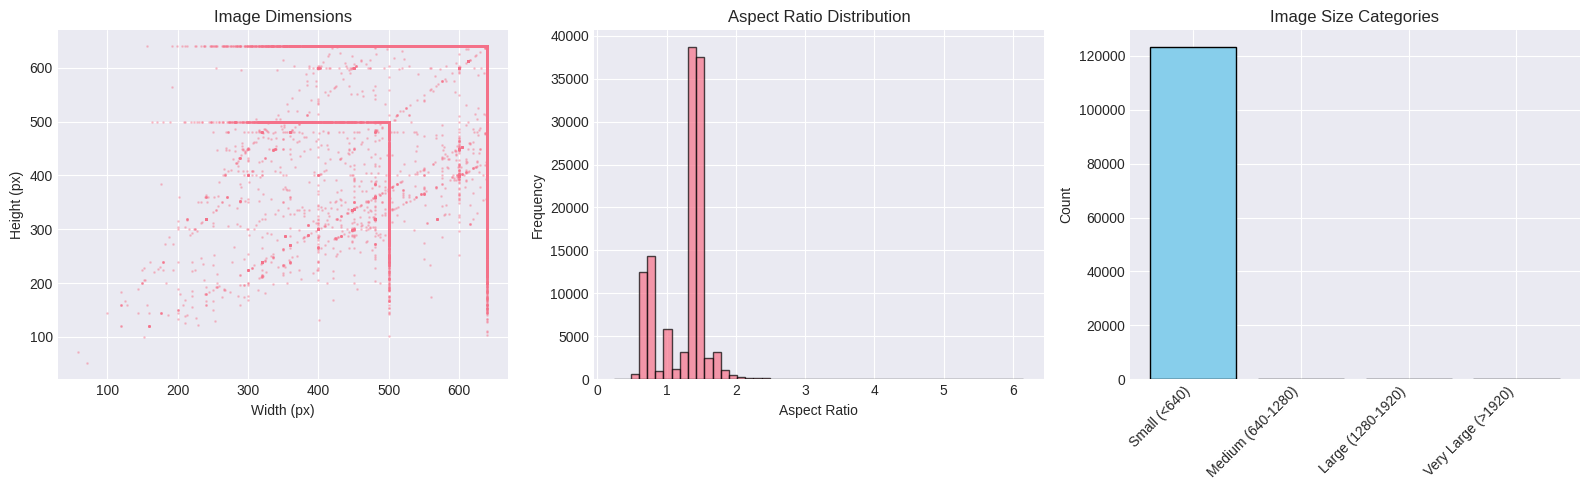

In [ ]:
# Image Dimension Visualization

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].scatter(coco_images['width'], coco_images['height'], alpha=0.3, s=1)
axes[0].set_xlabel('Width (px)')
axes[0].set_ylabel('Height (px)')
axes[0].set_title('Image Dimensions')

axes[1].hist(coco_images['aspect_ratio'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Aspect Ratio')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Aspect Ratio Distribution')

size_counts = coco_images['size_category'].value_counts().sort_index()
axes[2].bar(range(len(size_counts)), size_counts.values, color='skyblue', edgecolor='black')
axes[2].set_xticks(range(len(size_counts)))
axes[2].set_xticklabels(size_counts.index, rotation=45, ha='right')
axes[2].set_ylabel('Count')
axes[2].set_title('Image Size Categories')

plt.tight_layout()
plt.show()

In [ ]:
# Object Category Analysis

print(f"Total Categories: {len(coco_categories)}")

category_counts = coco_objects['category_id'].value_counts()
category_names = coco_categories.set_index('id')['name'].to_dict()
category_counts_named = pd.Series({category_names[k]: v for k, v in category_counts.items()})

print("\nTop 10 Object Categories:")
for i, (cat, count) in enumerate(category_counts_named.head(10).items(), 1):
    print(f"  {i}. {cat}: {count:,}")

COCO OBJECT CATEGORIES

Total Categories: 80

Top 10 Most Common Objects:
   1. person: 273,469
   2. car: 45,799
   3. chair: 40,282
   4. book: 25,876
   5. bottle: 25,367
   6. cup: 21,549
   7. dining table: 16,411
   8. bowl: 14,984
   9. traffic light: 13,521
   10. handbag: 12,894


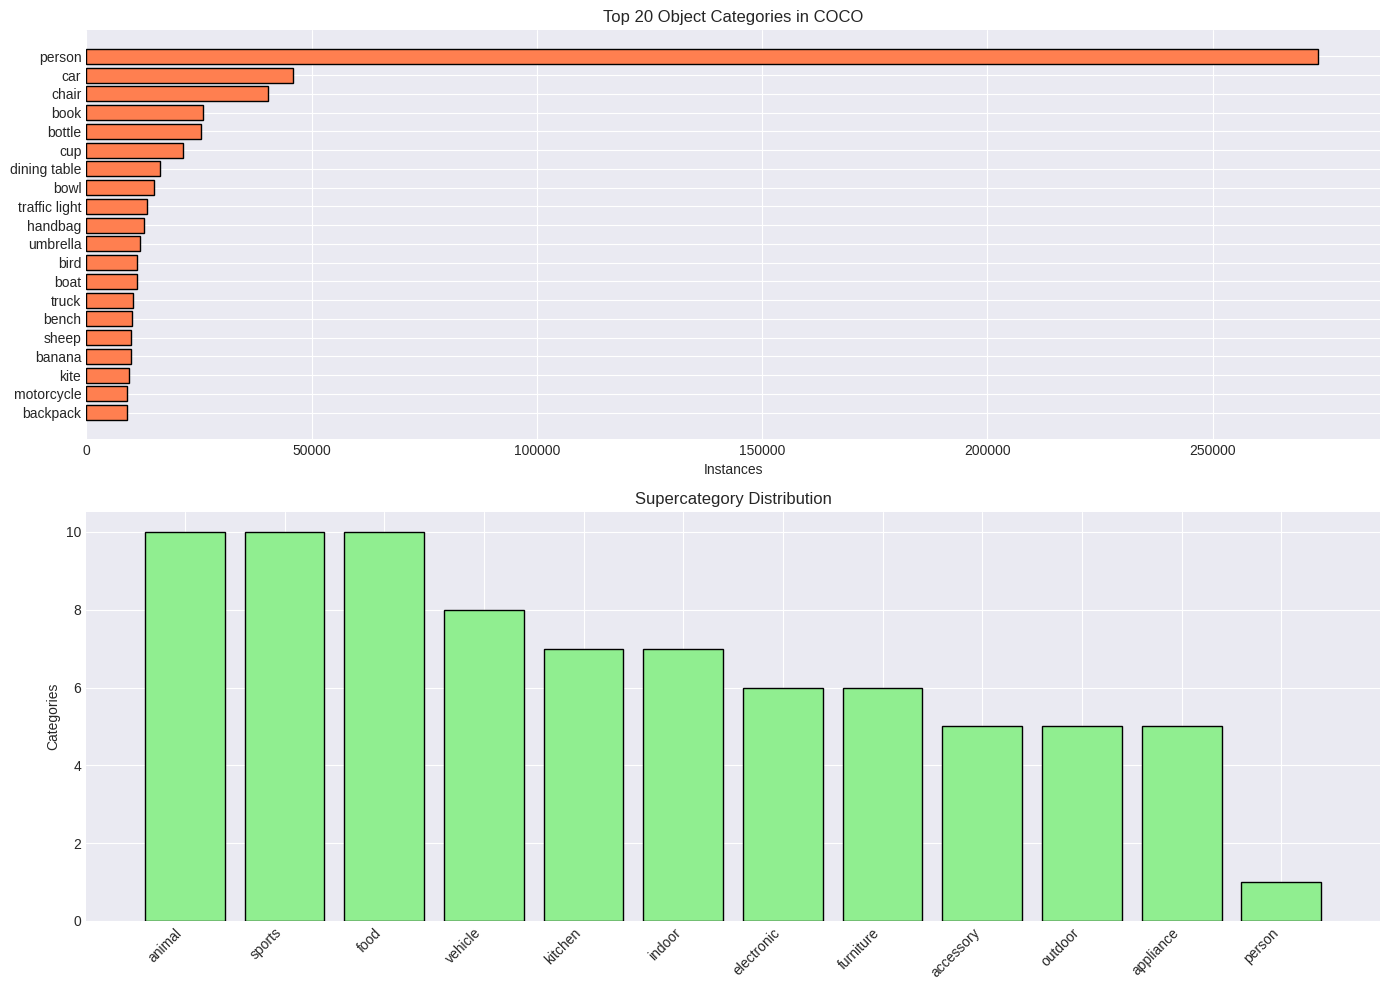

In [ ]:
# Object Category Visualization

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

top_20 = category_counts_named.head(20)
axes[0].barh(range(len(top_20)), top_20.values, color='coral', edgecolor='black')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20.index)
axes[0].set_xlabel('Instances')
axes[0].set_title('Top 20 Object Categories in COCO')
axes[0].invert_yaxis()

supercategory_counts = coco_categories['supercategory'].value_counts()
axes[1].bar(range(len(supercategory_counts)), supercategory_counts.values, color='lightgreen', edgecolor='black')
axes[1].set_xticks(range(len(supercategory_counts)))
axes[1].set_xticklabels(supercategory_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Categories')
axes[1].set_title('Supercategory Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Select Assistive-Relevant Classes

ASSISTIVE_CLASSES_LIST = [
    'person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck',
    'traffic light', 'stop sign',
    'bench', 'chair', 'couch', 'potted plant', 'dining table',
    'door', 'tv', 'laptop', 'cell phone', 'book', 'clock',
    'bottle', 'cup', 'fork', 'knife', 'spoon', 'bowl'
]

print(f"Selected Assistive Classes: {len(ASSISTIVE_CLASSES_LIST)}")

relevant_categories = coco_categories[coco_categories['name'].isin(ASSISTIVE_CLASSES_LIST)]
relevant_category_ids = relevant_categories['id'].tolist()

relevant_objects = coco_objects[coco_objects['category_id'].isin(relevant_category_ids)]
relevant_image_ids = relevant_objects['image_id'].unique()

print(f"Relevant Object Annotations: {len(relevant_objects):,}")
print(f"Images with Relevant Objects: {len(relevant_image_ids):,}")

SELECTED ASSISTIVE CLASSES

Total classes selected: 25

Class distribution in COCO:
   person: 273,469
   bicycle: 7,429
   car: 45,799
   motorcycle: 9,096
   bus: 6,354
   truck: 10,388
   traffic light: 13,521
   stop sign: 2,058
   bench: 10,251
   chair: 40,282
   couch: 6,040
   potted plant: 8,995
   dining table: 16,411
   tv: 6,093
   laptop: 5,201
   cell phone: 6,696
   book: 25,876
   clock: 6,601
   bottle: 25,367
   cup: 21,549
   fork: 5,694
   knife: 8,096
   spoon: 6,418
   bowl: 14,984

Filtered subset:
   Relevant objects: 582,668
   Images with relevant objects: 96,090


In [ ]:
# Load Road Sign Dataset

xml_files = os.listdir(os.path.join(ROAD_SIGN_PATH, "annotations"))
image_files = os.listdir(os.path.join(ROAD_SIGN_PATH, "images"))

print(f"Road Sign Dataset:")
print(f"  Annotation files: {len(xml_files)}")
print(f"  Image files: {len(image_files)}")

ROAD SIGN DATASET

Files: ['annotations', 'images']
Annotation files: 877
Image files: 877


In [ ]:
# Parse Road Sign Annotations

records = []
XML_DIR = os.path.join(ROAD_SIGN_PATH, "annotations")

for xml_file in os.listdir(XML_DIR):
    xml_path = os.path.join(XML_DIR, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    filename = root.find("filename").text
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)
    
    for obj in root.findall("object"):
        cls = obj.find("name").text
        bbox = obj.find("bndbox")
        records.append({
            "filename": filename,
            "class": cls,
            "width": width,
            "height": height,
            "xmin": int(bbox.find("xmin").text),
            "ymin": int(bbox.find("ymin").text),
            "xmax": int(bbox.find("xmax").text),
            "ymax": int(bbox.find("ymax").text)
        })

road_signs_df = pd.DataFrame(records)
print(f"Parsed {len(road_signs_df)} annotations from {road_signs_df['filename'].nunique()} images")

Road signs parsed: 1244 annotations from 877 images


In [ ]:
# Road Sign Statistics

print("Road Sign Class Distribution:")
for cls, count in road_signs_df['class'].value_counts().items():
    print(f"  {cls}: {count} ({100*count/len(road_signs_df):.1f}%)")

signs_per_image = road_signs_df.groupby('filename').size()
print(f"\nSigns per image: {signs_per_image.mean():.2f} avg, max: {signs_per_image.max()}")

ROAD SIGN ANALYSIS

Annotations: 1,244
Unique images: 877
Classes: 4

Class distribution:
   speedlimit: 783 (62.9%)
   crosswalk: 200 (16.1%)
   trafficlight: 170 (13.7%)
   stop: 91 (7.3%)

Signs per image: 1.42 avg, max: 8


In [ ]:
# Bounding Box Analysis

road_signs_df['bbox_width'] = road_signs_df['xmax'] - road_signs_df['xmin']
road_signs_df['bbox_height'] = road_signs_df['ymax'] - road_signs_df['ymin']
road_signs_df['bbox_area'] = road_signs_df['bbox_width'] * road_signs_df['bbox_height']

road_signs_df['bbox_size_category'] = pd.cut(
    road_signs_df['bbox_area'], 
    bins=[0, 5000, 20000, 50000, 1000000],
    labels=['Small', 'Medium', 'Large', 'Very Large']
)

print("Bounding Box Statistics:")
print(f"  Mean Width: {road_signs_df['bbox_width'].mean():.1f}px")
print(f"  Mean Height: {road_signs_df['bbox_height'].mean():.1f}px")
print(f"  Mean Area: {road_signs_df['bbox_area'].mean():.1f}px^2")

BOUNDING BOX ANALYSIS

Dimensions - Width: 53.5px, Height: 60.3px
Area: 5249.7px^2 avg

Size distribution:
bbox_size_category
Small         932
Medium        249
Large          47
Very Large     16
Name: count, dtype: int64


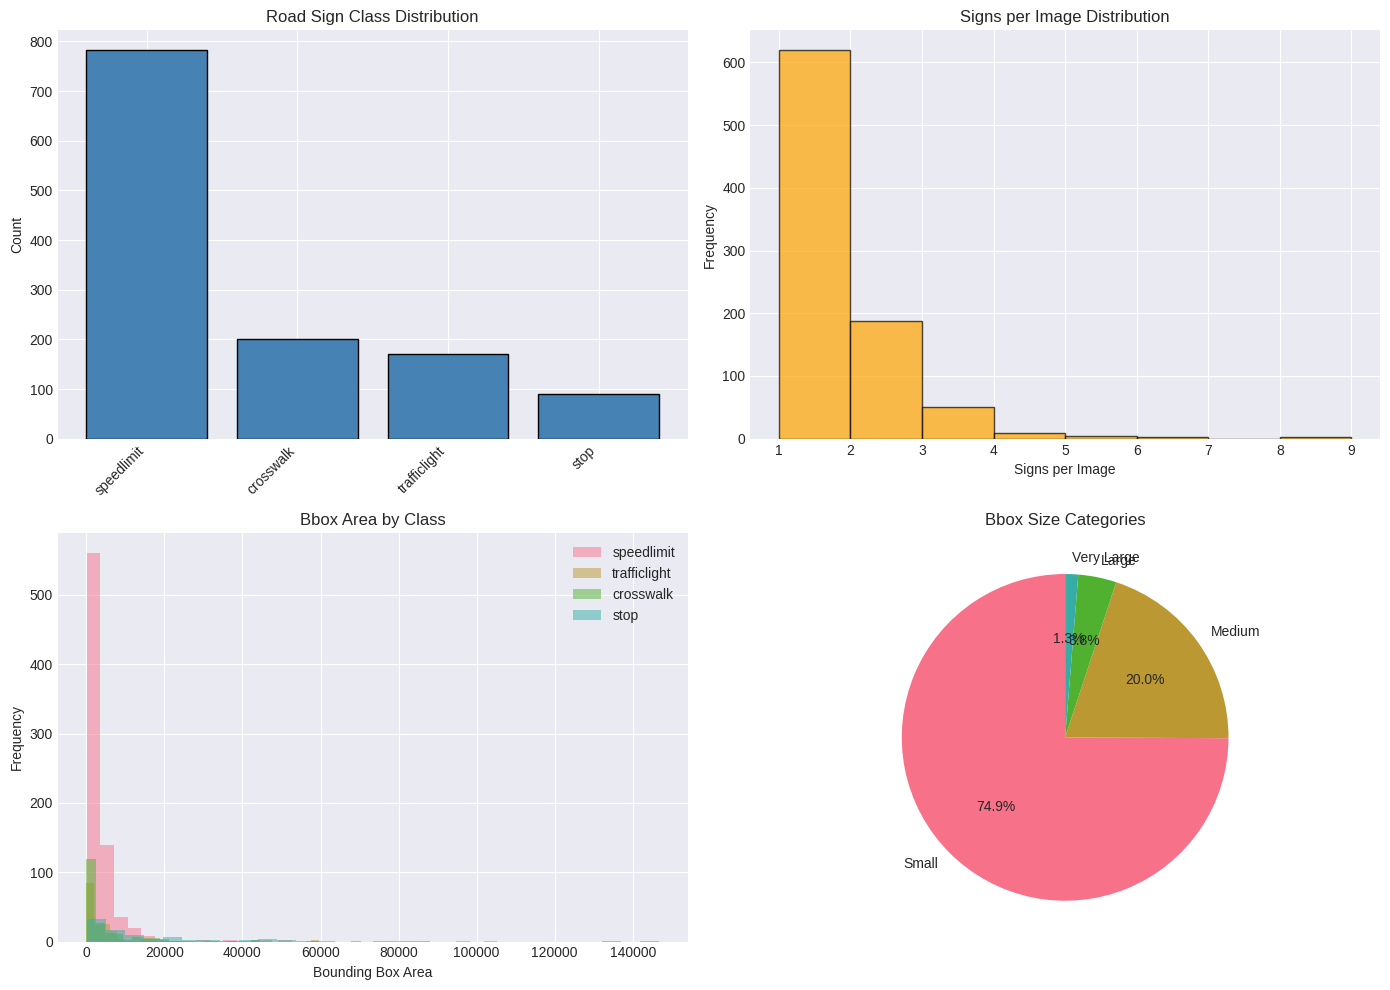

In [ ]:
# Road Sign Dataset Visualization

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

class_counts = road_signs_df['class'].value_counts()
axes[0, 0].bar(range(len(class_counts)), class_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xticks(range(len(class_counts)))
axes[0, 0].set_xticklabels(class_counts.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Road Sign Class Distribution')

axes[0, 1].hist(signs_per_image, bins=range(1, signs_per_image.max() + 2), edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Signs per Image')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Signs per Image Distribution')

for cls in road_signs_df['class'].unique():
    axes[1, 0].hist(road_signs_df[road_signs_df['class'] == cls]['bbox_area'], bins=30, alpha=0.5, label=cls)
axes[1, 0].set_xlabel('Bounding Box Area')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Bounding Box Area by Class')
axes[1, 0].legend()

size_cat = road_signs_df['bbox_size_category'].value_counts().sort_index()
axes[1, 1].pie(size_cat.values, labels=size_cat.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Bounding Box Size Categories')

plt.tight_layout()
plt.show()

In [ ]:
# Dataset Summary

print("Combined Dataset Summary")
print("=" * 40)
print("\nCOCO Dataset:")
print(f"  Total Images: {len(coco_images):,}")
print(f"  Filtered (Assistive): {len(relevant_image_ids):,}")
print(f"  Selected Classes: {len(ASSISTIVE_CLASSES_LIST)}")

print("\nRoad Sign Dataset:")
print(f"  Images: {road_signs_df['filename'].nunique():,}")
print(f"  Annotations: {len(road_signs_df):,}")
print(f"  Classes: {list(road_signs_df['class'].unique())}")

DATASET SUMMARY

COCO Dataset:
   Total images: 123,287
   Filtered (assistive): 96,090
   Assistive classes: 25

Road Sign Dataset:
   Images: 877
   Annotations: 1,244
   Classes: ['speedlimit', 'trafficlight', 'crosswalk', 'stop']


In [ ]:
# Unified Class Mapping

ASSISTIVE_CLASSES = {
    'person': 0, 'car': 1, 'bicycle': 2, 'motorcycle': 3, 'bus': 4, 'truck': 5,
    'traffic light': 6, 'stop sign': 7,
    'bench': 8, 'chair': 9, 'couch': 10, 'potted plant': 11, 'dining table': 12,
    'tv': 13, 'laptop': 14, 'cell phone': 15, 'book': 16, 'clock': 17,
    'bottle': 18, 'cup': 19, 'fork': 20, 'knife': 21, 'spoon': 22, 'bowl': 23
}

ROAD_SIGN_CLASSES = {
    'trafficlight': 24, 'stop': 25, 'speedlimit': 26, 'crosswalk': 27
}

ALL_CLASSES = {**ASSISTIVE_CLASSES, **ROAD_SIGN_CLASSES}
CLASS_NAMES = list(ALL_CLASSES.keys())

PRIORITY_CLASSES = ['person', 'car', 'bicycle', 'motorcycle', 'bus', 'truck', 
                    'traffic light', 'stop sign', 'crosswalk', 'stop', 'trafficlight']

coco_to_our_class = {}
for cat in coco_instances['categories']:
    if cat['name'] in ASSISTIVE_CLASSES:
        coco_to_our_class[cat['id']] = ASSISTIVE_CLASSES[cat['name']]

print(f"COCO Assistive Classes: {len(ASSISTIVE_CLASSES)}")
print(f"Road Sign Classes: {len(ROAD_SIGN_CLASSES)}")
print(f"Total Classes: {len(ALL_CLASSES)}")
print(f"Priority Classes: {len(PRIORITY_CLASSES)}")

UNIFIED CLASS CONFIGURATION
COCO Assistive Classes: 24
Road Sign Classes: 4
Total Classes: 28
Priority Classes: 11

Class Names:
   [P] 0: person
   [P] 1: car
   [P] 2: bicycle
   [P] 3: motorcycle
   [P] 4: bus
   [P] 5: truck
   [P] 6: traffic light
   [P] 7: stop sign
       8: bench
       9: chair
       10: couch
       11: potted plant
       12: dining table
       13: tv
       14: laptop
       15: cell phone
       16: book
       17: clock
       18: bottle
       19: cup
       20: fork
       21: knife
       22: spoon
       23: bowl
   [P] 24: trafficlight
   [P] 25: stop
       26: speedlimit
   [P] 27: crosswalk


In [ ]:
# Create YOLO Dataset Directory Structure

OUTPUT_DIR = "/kaggle/working/assistive_vision_dataset"
YOLO_DIR = os.path.join(OUTPUT_DIR, "yolo_format")

for split in ['train', 'val', 'test']:
    for folder in ['images', 'labels']:
        os.makedirs(os.path.join(YOLO_DIR, folder, split), exist_ok=True)
    
print(f"YOLO directory structure created at: {YOLO_DIR}")

Created YOLO directory structure at: /kaggle/working/assistive_vision_dataset/yolo_format


In [ ]:
# Data Preprocessing Utilities

import cv2
from PIL import ImageEnhance, ImageFilter

def preprocess_image(image, target_size=640):
    """Resize and normalize image maintaining aspect ratio."""
    if isinstance(image, str):
        image = Image.open(image).convert('RGB')
    
    w, h = image.size
    scale = target_size / max(w, h)
    new_w, new_h = int(w * scale), int(h * scale)
    image = image.resize((new_w, new_h), Image.LANCZOS)
    
    result = Image.new('RGB', (target_size, target_size), (128, 128, 128))
    paste_x = (target_size - new_w) // 2
    paste_y = (target_size - new_h) // 2
    result.paste(image, (paste_x, paste_y))
    
    return result, scale, (paste_x, paste_y)

def augment_image(image, aug_type='random'):
    """Apply data augmentation."""
    if aug_type == 'brightness':
        return ImageEnhance.Brightness(image).enhance(random.uniform(0.7, 1.3))
    elif aug_type == 'contrast':
        return ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    elif aug_type == 'blur':
        return image.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))
    elif aug_type == 'random':
        return augment_image(image, random.choice(['brightness', 'contrast', 'blur']))
    return image

def coco_to_yolo_bbox(bbox, img_w, img_h):
    """Convert COCO bbox [x, y, w, h] to YOLO normalized format."""
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    return [x_center, y_center, w / img_w, h / img_h]

print("Preprocessing utilities defined.")

Preprocessing and augmentation utilities defined


In [ ]:
# Convert COCO to YOLO Format

def process_coco_to_yolo(split_name='train', source_split='train', max_images=10000):
    """Convert COCO annotations to YOLO format."""
    print(f"\nProcessing COCO {source_split} -> {split_name}...")
    
    if source_split == 'train':
        instances = coco_instances_train
        img_dir = COCO_IMAGES_TRAIN
    else:
        instances = coco_instances_val
        img_dir = COCO_IMAGES_VAL
    
    img_to_anns = {}
    for ann in instances['annotations']:
        if ann['category_id'] in coco_to_our_class:
            img_id = ann['image_id']
            if img_id not in img_to_anns:
                img_to_anns[img_id] = []
            img_to_anns[img_id].append(ann)
    
    img_info = {img['id']: img for img in instances['images']}
    valid_img_ids = list(img_to_anns.keys())[:max_images]
    
    if os.path.exists(img_dir):
        available_files = set(os.listdir(img_dir))
    else:
        available_files = set()
    
    processed = 0
    
    for img_id in tqdm(valid_img_ids, desc=f"COCO {split_name}"):
        if img_id not in img_info:
            continue
            
        img = img_info[img_id]
        img_filename = img['file_name']
        img_w, img_h = img['width'], img['height']
        
        src_img_path = os.path.join(img_dir, img_filename)
        
        if not os.path.exists(src_img_path):
            base_filename = os.path.basename(img_filename)
            src_img_path = os.path.join(img_dir, base_filename)
            img_filename = base_filename
        
        if not os.path.exists(src_img_path):
            img_id_str = str(img_id).zfill(12)
            matching_files = [f for f in available_files if img_id_str in f]
            if matching_files:
                img_filename = matching_files[0]
                src_img_path = os.path.join(img_dir, img_filename)
        
        if not os.path.exists(src_img_path):
            continue
        
        labels = []
        for ann in img_to_anns[img_id]:
            class_id = coco_to_our_class[ann['category_id']]
            bbox = coco_to_yolo_bbox(ann['bbox'], img_w, img_h)
            if all(0 <= v <= 1 for v in bbox) and bbox[2] > 0 and bbox[3] > 0:
                labels.append([class_id] + bbox)
        
        if labels:
            label_path = os.path.join(YOLO_DIR, "labels", split_name, f"{Path(img_filename).stem}.txt")
            with open(label_path, 'w') as f:
                for lbl in labels:
                    f.write(f"{int(lbl[0])} {lbl[1]:.6f} {lbl[2]:.6f} {lbl[3]:.6f} {lbl[4]:.6f}\n")
            
            dst_img_path = os.path.join(YOLO_DIR, "images", split_name, img_filename)
            if not os.path.exists(dst_img_path):
                try:
                    os.symlink(src_img_path, dst_img_path)
                except:
                    shutil.copy2(src_img_path, dst_img_path)
            processed += 1
    
    print(f"  Processed: {processed} images")
    return processed

coco_train_count = process_coco_to_yolo('train', 'train', max_images=10000)
coco_val_count = process_coco_to_yolo('val', 'val', max_images=2000)
coco_test_count = process_coco_to_yolo('test', 'val', max_images=1500)

print(f"\nCOCO Conversion: Train={coco_train_count}, Val={coco_val_count}, Test={coco_test_count}")


Processing COCO train -> train...
   Found 64516 images, processing 10000...


COCO train:   0%|          | 0/10000 [00:00<?, ?it/s]

   Processed: 10000 images

Processing COCO val -> val...
   Found 31574 images, processing 2000...


COCO val:   0%|          | 0/2000 [00:00<?, ?it/s]

   Processed: 251 images
   Skipped - No info: 0, No file: 1749, No labels: 0

Processing COCO val -> test...
   Found 31574 images, processing 1500...


COCO test:   0%|          | 0/1500 [00:00<?, ?it/s]

   Processed: 201 images
   Skipped - No info: 0, No file: 1299, No labels: 0

COCO Summary: Train=10000, Val=251, Test=201


In [ ]:
# Convert Road Signs and Merge with COCO

def process_road_signs_to_yolo():
    """Convert Road Sign dataset to YOLO format."""
    print("\nProcessing Road Signs...")
    
    unique_imgs = road_signs_df['filename'].unique().copy()
    np.random.seed(42)
    np.random.shuffle(unique_imgs)
    
    n = len(unique_imgs)
    train_idx = int(n * 0.7)
    val_idx = int(n * 0.85)
    
    splits = {
        'train': unique_imgs[:train_idx], 
        'val': unique_imgs[train_idx:val_idx],
        'test': unique_imgs[val_idx:]
    }
    
    counts = {}
    src_img_dir = os.path.join(ROAD_SIGN_PATH, "images")
    
    for split, imgs in splits.items():
        processed = 0
        for img_name in tqdm(imgs, desc=f"Road signs {split}"):
            img_anns = road_signs_df[road_signs_df['filename'] == img_name]
            if len(img_anns) == 0:
                continue
                
            first_ann = img_anns.iloc[0]
            img_w, img_h = first_ann['width'], first_ann['height']
            
            labels = []
            for _, row in img_anns.iterrows():
                class_name = row['class'].lower()
                class_id = ROAD_SIGN_CLASSES.get(class_name, -1)
                if class_id == -1:
                    continue
                
                x_center = ((row['xmin'] + row['xmax']) / 2) / img_w
                y_center = ((row['ymin'] + row['ymax']) / 2) / img_h
                w = (row['xmax'] - row['xmin']) / img_w
                h = (row['ymax'] - row['ymin']) / img_h
                
                if all(0 <= v <= 1 for v in [x_center, y_center, w, h]) and w > 0 and h > 0:
                    labels.append([class_id, x_center, y_center, w, h])
            
            if labels:
                stem = Path(img_name).stem
                label_path = os.path.join(YOLO_DIR, "labels", split, f"{stem}.txt")
                with open(label_path, 'w') as f:
                    for lbl in labels:
                        f.write(f"{int(lbl[0])} {lbl[1]:.6f} {lbl[2]:.6f} {lbl[3]:.6f} {lbl[4]:.6f}\n")
                
                src_path = os.path.join(src_img_dir, img_name)
                dst_path = os.path.join(YOLO_DIR, "images", split, img_name)
                
                if os.path.exists(src_path) and not os.path.exists(dst_path):
                    try:
                        os.symlink(src_path, dst_path)
                    except:
                        shutil.copy2(src_path, dst_path)
                processed += 1
        
        counts[split] = processed
        print(f"  {split}: {processed} images")
    
    return counts

road_counts = process_road_signs_to_yolo()

print("\nCombined Dataset Summary:")
for split in ['train', 'val', 'test']:
    imgs = len(os.listdir(os.path.join(YOLO_DIR, "images", split)))
    lbls = len(os.listdir(os.path.join(YOLO_DIR, "labels", split)))
    print(f"  {split}: {imgs} images, {lbls} labels")


Processing Road Signs Dataset...


Road signs train:   0%|          | 0/613 [00:00<?, ?it/s]

   train: 613 images


Road signs val:   0%|          | 0/132 [00:00<?, ?it/s]

   val: 132 images


Road signs test:   0%|          | 0/132 [00:00<?, ?it/s]

   test: 132 images

COMBINED DATASET SUMMARY
   train: 10613 images, 10613 labels
   val: 383 images, 383 labels
   test: 333 images, 333 labels


In [ ]:
# Create YOLO Configuration File

yaml_content = f"""path: {YOLO_DIR}
train: images/train
val: images/val
test: images/test

nc: {len(ALL_CLASSES)}

names:
"""

for i, name in enumerate(CLASS_NAMES):
    yaml_content += f"  {i}: {name}\n"

yaml_path = os.path.join(YOLO_DIR, "data.yaml")
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print("Configuration saved to:", yaml_path)

DATA.YAML CONFIGURATION
# Assistive Vision Dataset Configuration
path: /kaggle/working/assistive_vision_dataset/yolo_format
train: images/train
val: images/val
test: images/test

nc: 28

names:
  0: person
  1: car
  2: bicycle
  3: motorcycle
  4: bus
  5: truck
  6: traffic light
  7: stop sign
  8: bench
  9: chair
  10: couch
  11: potted plant
  12: dining table
  13: tv
  14: laptop
  15: cell phone
  16: book
  17: clock
  18: bottle
  19: cup
  20: fork
  21: knife
  22: spoon
  23: bowl
  24: trafficlight
  25: stop
  26: speedlimit
  27: crosswalk

Saved to: /kaggle/working/assistive_vision_dataset/yolo_format/data.yaml


In [ ]:
# Train YOLOv8 Model

from ultralytics import YOLO
import time

print("=" * 60)
print("YOLOv8 Training")
print("=" * 60)

model = YOLO("yolov8s.pt")

start_time = time.time()

model.train(
    data=yaml_path,
    epochs=100,
    batch=BATCH_SIZE,
    imgsz=640,
    device=0,
    workers=NUM_WORKERS,
    project="/kaggle/working/runs",
    name="assistive_vision_v1",
    patience=15,
    save=True,
    save_period=10,
    pretrained=True,
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.1,
    amp=True,
    cache=True,
    verbose=True
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.1f} minutes")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
=== TRAIN DEBUG START ===
Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=False, angle=1.0, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/assistive_vision_dataset/yolo_format/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=No

In [ ]:
# Model Evaluation

print("=" * 60)
print("Model Evaluation")
print("=" * 60)

metrics = model.val()

print(f"\nValidation Metrics:")
print(f"  mAP@50:      {metrics.box.map50:.4f}")
print(f"  mAP@50-95:   {metrics.box.map:.4f}")
print(f"  Precision:   {metrics.box.mp:.4f}")
print(f"  Recall:      {metrics.box.mr:.4f}")

model_save_path = "/kaggle/working/assistive_vision_best.pt"
best_model_path = "/kaggle/working/runs/assistive_vision_v1/weights/best.pt"

if os.path.exists(best_model_path):
    shutil.copy2(best_model_path, model_save_path)
    print(f"\nBest model saved to: {model_save_path}")
else:
    model.save(model_save_path)

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

MODEL EVALUATION
Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 73 layers, 11,136,420 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 330.2±52.5 MB/s, size: 171.1 KB)
val: Scanning /kaggle/working/assistive_vision_dataset/yolo_format/labels/val.cache... 383 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 383/383 123.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 3.6it/s 6.8s<0.2s
                   all        383       2194      0.418       0.32      0.284      0.184
                person        123        598       0.71       0.45      0.507      0.298
                   car         62        223      0.453      0.323      0.284      0.168
               bicycle         58        131      0.457      0.443      0.413       0.23
            motorcycle         50        122      0.489      0.402    

In [ ]:
# Load Language Models (BLIP-2 and TrOCR)

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("=" * 60)
print("Loading Language Models")
print("=" * 60)

from transformers import (
    BlipProcessor, 
    BlipForConditionalGeneration,
    Blip2Processor,
    Blip2ForConditionalGeneration,
    TrOCRProcessor, 
    VisionEncoderDecoderModel
)

print("\nLoading BLIP-2...")
try:
    blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
    blip_model = Blip2ForConditionalGeneration.from_pretrained(
        "Salesforce/blip2-opt-2.7b",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto" if torch.cuda.is_available() else None
    )
    print("  BLIP-2 loaded successfully")
except Exception as e:
    print(f"  BLIP-2 failed, using BLIP-base: {e}")
    blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip_model = BlipForConditionalGeneration.from_pretrained(
        "Salesforce/blip-image-captioning-base",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    if torch.cuda.is_available():
        blip_model = blip_model.to("cuda")

print("\nLoading TrOCR...")
ocr_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
ocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

if torch.cuda.is_available():
    ocr_model = ocr_model.to("cuda").half()

print("\nAll models loaded successfully.")
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")

LOADING LANGUAGE MODELS


E0000 00:00:1769661610.218883      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769661610.266599      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769661610.690100      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769661610.690126      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769661610.690129      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769661610.690132      55 computation_placer.cc:177] computation placer already registered. Please check linka


Loading BLIP-2 Captioning Model...


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

   BLIP-2 loaded successfully

Loading TrOCR Model...


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Models loaded successfully!
GPU Memory - Allocated: 8.72 GB


In [ ]:
# Assistive Vision System Implementation

class AssistiveVisionSystem:
    """Multi-modal perception system combining detection, captioning, OCR, and TTS."""
    
    def __init__(self, yolo_model_path):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.yolo = YOLO(yolo_model_path)
        self.blip_processor = blip_processor
        self.blip_model = blip_model
        self.ocr_processor = ocr_processor
        self.ocr_model = ocr_model
        self.class_names = CLASS_NAMES
        self.priority_classes = PRIORITY_CLASSES
        print(f"System initialized on: {self.device}")
    
    def detect_objects(self, image_path, conf_threshold=0.25, iou_threshold=0.45):
        """Detect objects with NMS and confidence filtering."""
        results = self.yolo(image_path, conf=conf_threshold, iou=iou_threshold, verbose=False)[0]
        
        detections = []
        for box in results.boxes:
            class_id = int(box.cls[0])
            class_name = self.class_names[class_id] if class_id < len(self.class_names) else f"class_{class_id}"
            
            detections.append({
                'class': class_name,
                'class_id': class_id,
                'confidence': float(box.conf[0]),
                'bbox': box.xyxy[0].tolist(),
                'is_priority': class_name in self.priority_classes,
                'is_text_bearing': class_name in ['stop sign', 'traffic light', 'stop', 'speedlimit']
            })
        
        detections.sort(key=lambda x: (not x['is_priority'], -x['confidence']))
        return detections
    
    def generate_caption(self, image_path, reduce_hallucination=True):
        """Generate scene caption with hallucination reduction."""
        try:
            image = Image.open(image_path).convert('RGB')
            inputs = self.blip_processor(image, return_tensors="pt")
            
            if self.device == 'cuda':
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                output_ids = self.blip_model.generate(
                    **inputs,
                    max_length=50,
                    min_length=10,
                    num_beams=5,
                    repetition_penalty=1.5,
                    length_penalty=1.0,
                    early_stopping=True
                )
            
            caption = self.blip_processor.decode(output_ids[0], skip_special_tokens=True)
            
            if reduce_hallucination:
                uncertain_phrases = ['might be', 'could be', 'possibly', 'maybe', 'probably']
                for phrase in uncertain_phrases:
                    caption = caption.replace(phrase, '')
            
            return caption.strip()
        except Exception as e:
            return "Scene description unavailable"
    
    def extract_text_from_regions(self, image_path, detections):
        """Extract text from detected text-bearing regions using TrOCR."""
        texts = []
        image = Image.open(image_path).convert('RGB')
        
        for det in detections:
            if not det.get('is_text_bearing', False):
                continue
            
            try:
                x1, y1, x2, y2 = [int(v) for v in det['bbox']]
                pad = 5
                x1, y1 = max(0, x1-pad), max(0, y1-pad)
                x2, y2 = min(image.width, x2+pad), min(image.height, y2+pad)
                
                crop = image.crop((x1, y1, x2, y2))
                pixel_values = self.ocr_processor(crop, return_tensors="pt").pixel_values
                
                if self.device == 'cuda':
                    pixel_values = pixel_values.to(self.device).half()
                
                with torch.no_grad():
                    generated_ids = self.ocr_model.generate(pixel_values)
                
                text = self.ocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
                if text.strip():
                    texts.append({'text': text.strip(), 'source': det['class'], 'bbox': det['bbox']})
            except:
                continue
        
        return texts
    
    def calculate_position(self, bbox, image_width, image_height):
        """Calculate object position for spatial awareness."""
        x1, y1, x2, y2 = bbox
        center_x = (x1 + x2) / 2
        
        if center_x < image_width / 3:
            h_pos = "left"
        elif center_x > 2 * image_width / 3:
            h_pos = "right"
        else:
            h_pos = "center"
        
        obj_height = y2 - y1
        if obj_height > image_height * 0.5:
            distance = "very close"
        elif obj_height > image_height * 0.3:
            distance = "nearby"
        elif obj_height > image_height * 0.1:
            distance = "moderate distance"
        else:
            distance = "far"
        
        return h_pos, distance
    
    def fuse_scene_understanding(self, detections, caption, ocr_texts, image_size):
        """Fuse detections, OCR, and captions into structured scene understanding."""
        scene = {
            'priority_objects': [],
            'other_objects': [],
            'text_content': [],
            'scene_description': caption,
            'navigation_warnings': []
        }
        
        for det in detections:
            h_pos, distance = self.calculate_position(det['bbox'], image_size[0], image_size[1])
            obj_info = {
                'class': det['class'],
                'confidence': det['confidence'],
                'position': h_pos,
                'distance': distance
            }
            
            if det['is_priority']:
                scene['priority_objects'].append(obj_info)
                if distance in ['very close', 'nearby']:
                    scene['navigation_warnings'].append(f"{det['class']} {distance} on {h_pos}")
            else:
                scene['other_objects'].append(obj_info)
        
        scene['text_content'] = ocr_texts
        return scene
    
    def generate_audio_description(self, scene_understanding):
        """Generate natural language description for audio feedback."""
        parts = []
        
        if scene_understanding['navigation_warnings']:
            warnings = ', '.join(scene_understanding['navigation_warnings'][:3])
            parts.append(f"Attention: {warnings}.")
        
        parts.append(scene_understanding['scene_description'] + ".")
        
        if scene_understanding['other_objects']:
            obj_counts = Counter([o['class'] for o in scene_understanding['other_objects']])
            obj_list = ', '.join([f"{c} {n}" if c > 1 else n for n, c in obj_counts.most_common(3)])
            parts.append(f"Also visible: {obj_list}.")
        
        for text_item in scene_understanding['text_content'][:2]:
            parts.append(f"Sign reads: {text_item['text']}.")
        
        return ' '.join(parts)
    
    def analyze(self, image_path, visualize=False):
        """Complete analysis pipeline."""
        with Image.open(image_path) as img:
            image_size = img.size
        
        detections = self.detect_objects(image_path, conf_threshold=0.3, iou_threshold=0.45)
        caption = self.generate_caption(image_path, reduce_hallucination=True)
        ocr_texts = self.extract_text_from_regions(image_path, detections)
        scene = self.fuse_scene_understanding(detections, caption, ocr_texts, image_size)
        audio_desc = self.generate_audio_description(scene)
        
        if visualize:
            self.visualize_results(image_path, detections, caption, audio_desc)
        
        return {
            'detections': detections,
            'caption': caption,
            'ocr_texts': ocr_texts,
            'scene_understanding': scene,
            'audio_description': audio_desc,
            'num_objects': len(detections),
            'num_priority': len([d for d in detections if d['is_priority']])
        }
    
    def visualize_results(self, image_path, detections, caption, audio_desc):
        """Visualize detection results."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        img = Image.open(image_path)
        axes[0].imshow(img)
        
        for det in detections:
            x1, y1, x2, y2 = det['bbox']
            color = 'red' if det['is_priority'] else 'blue'
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color=color, linewidth=2)
            axes[0].add_patch(rect)
            axes[0].text(x1, y1-5, f"{det['class']} ({det['confidence']:.2f})",
                        color=color, fontsize=8, fontweight='bold',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        axes[0].set_title(f"Detections ({len(detections)} objects)")
        axes[0].axis('off')
        
        axes[1].axis('off')
        summary = f"Caption:\n{caption}\n\nAudio Output:\n{audio_desc}"
        axes[1].text(0.05, 0.95, summary, transform=axes[1].transAxes,
                    fontsize=10, verticalalignment='top', wrap=True)
        axes[1].set_title("Analysis Summary")
        
        plt.tight_layout()
        plt.savefig('/kaggle/working/analysis_result.png', dpi=150, bbox_inches='tight')
        plt.show()

system = AssistiveVisionSystem(model_save_path)
print("System ready for inference.")


INITIALIZING ASSISTIVE VISION SYSTEM
System initialized on: cuda
System ready for inference!


In [ ]:
# Audio Feedback System

from gtts import gTTS
from IPython.display import Audio, display
import io

class AudioFeedback:
    """Text-to-Speech system for audio feedback."""
    
    def __init__(self, lang='en', slow=False):
        self.lang = lang
        self.slow = slow
    
    def text_to_speech(self, text, output_path=None):
        """Convert text to speech."""
        try:
            tts = gTTS(text=text, lang=self.lang, slow=self.slow)
            
            if output_path:
                tts.save(output_path)
                return output_path
            else:
                audio_buffer = io.BytesIO()
                tts.write_to_fp(audio_buffer)
                audio_buffer.seek(0)
                return audio_buffer.read()
        except Exception as e:
            print(f"TTS Error: {e}")
            return None
    
    def play_feedback(self, text):
        """Generate and play audio."""
        audio_data = self.text_to_speech(text)
        if audio_data:
            display(Audio(audio_data, autoplay=True))
            return True
        return False
    
    def save_feedback(self, text, filename):
        """Save audio to file."""
        output_path = f"/kaggle/working/{filename}"
        result = self.text_to_speech(text, output_path)
        if result:
            print(f"Audio saved: {output_path}")
        return result

audio_system = AudioFeedback()
print("Audio system initialized.")

AUDIO FEEDBACK SYSTEM
Audio system ready!


In [ ]:
# Evaluation Metrics

from sklearn.metrics import precision_recall_fscore_support
import time

class EvaluationMetrics:
    """Evaluation for detection, captioning, and full pipeline."""
    
    def __init__(self, system):
        self.system = system
    
    def evaluate_detection(self, test_dir, num_samples=100):
        """Evaluate object detection performance."""
        print("\nDetection Evaluation")
        
        test_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))][:num_samples]
        
        all_detections = []
        inference_times = []
        
        for img_name in tqdm(test_images, desc="Detection"):
            img_path = os.path.join(test_dir, img_name)
            
            start_time = time.time()
            results = self.system.yolo(img_path, verbose=False)[0]
            inference_times.append(time.time() - start_time)
            
            for box in results.boxes:
                all_detections.append({
                    'image': img_name,
                    'class': int(box.cls[0]),
                    'confidence': float(box.conf[0])
                })
        
        metrics = {
            'num_images': len(test_images),
            'total_detections': len(all_detections),
            'avg_detections_per_image': len(all_detections) / len(test_images),
            'avg_inference_time_ms': np.mean(inference_times) * 1000,
            'fps': 1.0 / np.mean(inference_times),
            'confidence_mean': np.mean([d['confidence'] for d in all_detections]) if all_detections else 0
        }
        
        print(f"  Images: {metrics['num_images']}")
        print(f"  Avg detections/image: {metrics['avg_detections_per_image']:.2f}")
        print(f"  Inference: {metrics['avg_inference_time_ms']:.2f}ms ({metrics['fps']:.1f} FPS)")
        
        return metrics
    
    def evaluate_full_pipeline(self, test_dir, num_samples=30):
        """Evaluate complete pipeline."""
        print("\nFull Pipeline Evaluation")
        
        test_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))][:num_samples]
        
        results = []
        total_times = []
        
        for img_name in tqdm(test_images, desc="Pipeline"):
            img_path = os.path.join(test_dir, img_name)
            
            start_time = time.time()
            result = self.system.analyze(img_path, visualize=False)
            total_times.append(time.time() - start_time)
            
            results.append({
                'image': img_name,
                'num_objects': result['num_objects'],
                'num_priority': result['num_priority'],
                'has_ocr': len(result.get('ocr_texts', [])) > 0
            })
        
        metrics = {
            'num_images': len(test_images),
            'avg_objects': np.mean([r['num_objects'] for r in results]),
            'avg_priority_objects': np.mean([r['num_priority'] for r in results]),
            'avg_total_time_ms': np.mean(total_times) * 1000,
            'pipeline_fps': 1.0 / np.mean(total_times)
        }
        
        print(f"  Images: {metrics['num_images']}")
        print(f"  Avg objects: {metrics['avg_objects']:.1f}")
        print(f"  Pipeline: {metrics['avg_total_time_ms']:.2f}ms ({metrics['pipeline_fps']:.2f} FPS)")
        
        return metrics

evaluator = EvaluationMetrics(system)

test_dir = os.path.join(YOLO_DIR, "images", "test")
if not os.path.exists(test_dir) or not os.listdir(test_dir):
    test_dir = os.path.join(YOLO_DIR, "images", "val")

detection_metrics = evaluator.evaluate_detection(test_dir, num_samples=50)
pipeline_metrics = evaluator.evaluate_full_pipeline(test_dir, num_samples=20)


DETECTION EVALUATION


Evaluating detection:   0%|          | 0/50 [00:00<?, ?it/s]

   Images: 50
   Total detections: 181
   Avg detections/image: 3.62
   Inference time: 88.51ms
   FPS: 11.3
   Avg confidence: 0.609 +/- 0.249

CAPTIONING EVALUATION


Evaluating captioning:   0%|          | 0/30 [00:00<?, ?it/s]

   Images: 30
   Avg caption length: 8.5 words
   Generation time: 949.37ms

FULL PIPELINE EVALUATION


Full pipeline:   0%|          | 0/20 [00:00<?, ?it/s]


Analyzing: road521.png
   Detected 1 objects
   Caption: a street sign on a pole in front of a building
   OCR: ['80']
   Audio: a street sign on a pole in front of a building. Also visible: speedlimit. Sign reads: 80.

Analyzing: 000000170099.jpg
   Detected 2 objects
   Caption: a man wearing a red tie
   Audio: Attention: person very close on left. a man wearing a red tie. Also visible: couch.

Analyzing: road45.png
   Detected 11 objects
   Caption: a man riding a bike in the snow
   Audio: a man riding a bike in the snow.

Analyzing: 000000135670.jpg
   Detected 2 objects
   Caption: a bicycle is hanging on the side of a train
   Audio: Attention: bus very close on center. a bicycle is hanging on the side of a train.

Analyzing: road495.png
   Detected 1 objects
   Caption: a street sign on a pole in front of a tall building
   Audio: a street sign on a pole in front of a tall building.

Analyzing: 000000017379.jpg
   Detected 1 objects
   Caption: a bathroom with two sinks and a

In [ ]:
# Training Results Visualization

print("=" * 60)
print("Training Results")
print("=" * 60)

results_dir = "/kaggle/working/runs/assistive_vision_v1"

if os.path.exists(results_dir):
    results_img = os.path.join(results_dir, "results.png")
    if os.path.exists(results_img):
        img = Image.open(results_img)
        plt.figure(figsize=(14, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title("YOLOv8 Training Curves")
        plt.savefig('/kaggle/working/training_curves.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    confusion_path = os.path.join(results_dir, "confusion_matrix.png")
    if os.path.exists(confusion_path):
        img = Image.open(confusion_path)
        plt.figure(figsize=(12, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Confusion Matrix")
        plt.show()
    
    pr_path = os.path.join(results_dir, "PR_curve.png")
    if os.path.exists(pr_path):
        img = Image.open(pr_path)
        plt.figure(figsize=(10, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Precision-Recall Curve")
        plt.show()
else:
    print("Training results directory not found.")

TRAINING RESULTS
Training results not found. Run training first.


In [ ]:
# Complete Inference Function

def run_assistive_analysis(image_path, save_audio=True, visualize=True):
    """End-to-end analysis with audio output."""
    print("\n" + "=" * 60)
    print("Assistive Vision Analysis")
    print("=" * 60)
    
    result = system.analyze(image_path, visualize=visualize)
    
    if save_audio:
        output_file = f"audio_{Path(image_path).stem}.mp3"
        audio_system.save_feedback(result['audio_description'], output_file)
        result['audio_file'] = f"/kaggle/working/{output_file}"
    
    audio_system.play_feedback(result['audio_description'])
    
    return result

print("Usage: result = run_assistive_analysis('/path/to/image.jpg')")

Inference function ready: run_assistive_analysis(image_path)


In [ ]:
# Test Set Evaluation

print("=" * 60)
print("Test Set Evaluation")
print("=" * 60)

test_images_dir = os.path.join(YOLO_DIR, "images", "test")
if not os.path.exists(test_images_dir) or not os.listdir(test_images_dir):
    test_images_dir = os.path.join(YOLO_DIR, "images", "val")

print(f"Test directory: {test_images_dir}")

test_metrics = model.val(data=yaml_path, split='test' if 'test' in test_images_dir else 'val')

print(f"\nTest Results:")
print(f"  mAP@50:      {test_metrics.box.map50:.4f}")
print(f"  mAP@50-95:   {test_metrics.box.map:.4f}")
print(f"  Precision:   {test_metrics.box.mp:.4f}")
print(f"  Recall:      {test_metrics.box.mr:.4f}")
f1 = 2 * test_metrics.box.mp * test_metrics.box.mr / (test_metrics.box.mp + test_metrics.box.mr + 1e-8)
print(f"  F1 Score:    {f1:.4f}")

print("\nSpeed Benchmark:")
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png'))][:20]
times = []
for img_name in test_images:
    img_path = os.path.join(test_images_dir, img_name)
    start = time.time()
    _ = model(img_path, verbose=False)
    times.append(time.time() - start)

print(f"  Avg Inference: {np.mean(times)*1000:.2f}ms")
print(f"  FPS: {1/np.mean(times):.1f}")

TEST SET EVALUATION

Test directory: /kaggle/working/assistive_vision_dataset/yolo_format/images/test

1. Object Detection Test Metrics:
Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 226.2±136.1 MB/s, size: 167.5 KB)
val: Scanning /kaggle/working/assistive_vision_dataset/yolo_format/labels/test... 333 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 333/333 463.0it/s 0.7s0.0s
val: New cache created: /kaggle/working/assistive_vision_dataset/yolo_format/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 5.4it/s 3.9s<0.2s
                   all        333       1780      0.421      0.305      0.285      0.193
                person         87        406      0.676      0.446       0.49      0.286
                   car         53        181       0.38      0.293      0.226      0.134
               bicycle     

In [ ]:
# Save Final Artifacts

print("=" * 60)
print("Saving Final Artifacts")
print("=" * 60)

final_output_dir = "/kaggle/working/final_model"
os.makedirs(final_output_dir, exist_ok=True)

yolo_final_path = os.path.join(final_output_dir, "yolo_assistive_vision.pt")
if os.path.exists(model_save_path):
    shutil.copy2(model_save_path, yolo_final_path)
    print(f"Model: {yolo_final_path}")

class_config = {
    'all_classes': ALL_CLASSES,
    'class_names': CLASS_NAMES,
    'priority_classes': PRIORITY_CLASSES,
    'num_classes': len(ALL_CLASSES)
}

config_path = os.path.join(final_output_dir, "class_config.json")
with open(config_path, 'w') as f:
    json.dump(class_config, f, indent=2)
print(f"Config: {config_path}")

system_config = {
    'model_architecture': 'YOLOv8s',
    'caption_model': 'BLIP-2',
    'ocr_model': 'TrOCR-base-printed',
    'tts_engine': 'gTTS',
    'num_classes': len(ALL_CLASSES),
    'training_epochs': 100,
    'image_size': 640
}

sys_config_path = os.path.join(final_output_dir, "system_config.json")
with open(sys_config_path, 'w') as f:
    json.dump(system_config, f, indent=2)
print(f"System config: {sys_config_path}")

if os.path.exists(results_dir):
    results_copy_dir = os.path.join(final_output_dir, "training_results")
    if not os.path.exists(results_copy_dir):
        shutil.copytree(results_dir, results_copy_dir)
    print(f"Training results: {results_copy_dir}")

print("\nArtifacts:")
for f in os.listdir(final_output_dir):
    fpath = os.path.join(final_output_dir, f)
    if os.path.isdir(fpath):
        print(f"  [DIR] {f}/")
    else:
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        print(f"  {f} ({size_mb:.2f} MB)")

SAVING FINAL ARTIFACTS
YOLO model: /kaggle/working/final_model/yolo_assistive_vision.pt
Class config: /kaggle/working/final_model/class_config.json
System config: /kaggle/working/final_model/system_config.json

Final Artifacts:
   yolo_assistive_vision.pt (21.34 MB)
   system_config.json (0.00 MB)
   class_config.json (0.00 MB)


# System Architecture

```
                         INPUT IMAGE
                              |
                              v
                    +--------------------+
                    |  YOLOv8 Detection  |
                    +--------------------+
                              |
              +---------------+---------------+
              |                               |
              v                               v
    +------------------+            +------------------+
    | Object Detection |            | Text Region      |
    | (28 classes)     |            | Identification   |
    +------------------+            +------------------+
                                              |
                                              v
                                    +------------------+
                                    |    TrOCR OCR     |
                                    +------------------+
                                              |
              +-------------------------------+
              |
              v
    +------------------+
    | BLIP-2 Captioning|
    +------------------+
              |
              v
    +------------------+
    |   Fusion Layer   |
    | - Detections     |
    | - OCR Text       |
    | - Scene Caption  |
    +------------------+
              |
              v
    +------------------+
    | Post-Processing  |
    | - NMS            |
    | - Confidence     |
    | - Spatial        |
    +------------------+
              |
              v
    +------------------+
    |  gTTS Audio      |
    +------------------+
              |
              v
         AUDIO OUTPUT
```

DEMO: COMPLETE SYSTEM OUTPUT

Running demo on 3 images...


DEMO IMAGE 1: road521.png

Analyzing: road521.png
   Detected 1 objects
   Caption: a street sign on a pole in front of a building
   OCR: ['80']
   Audio: a street sign on a pole in front of a building. Also visible: speedlimit. Sign reads: 80.


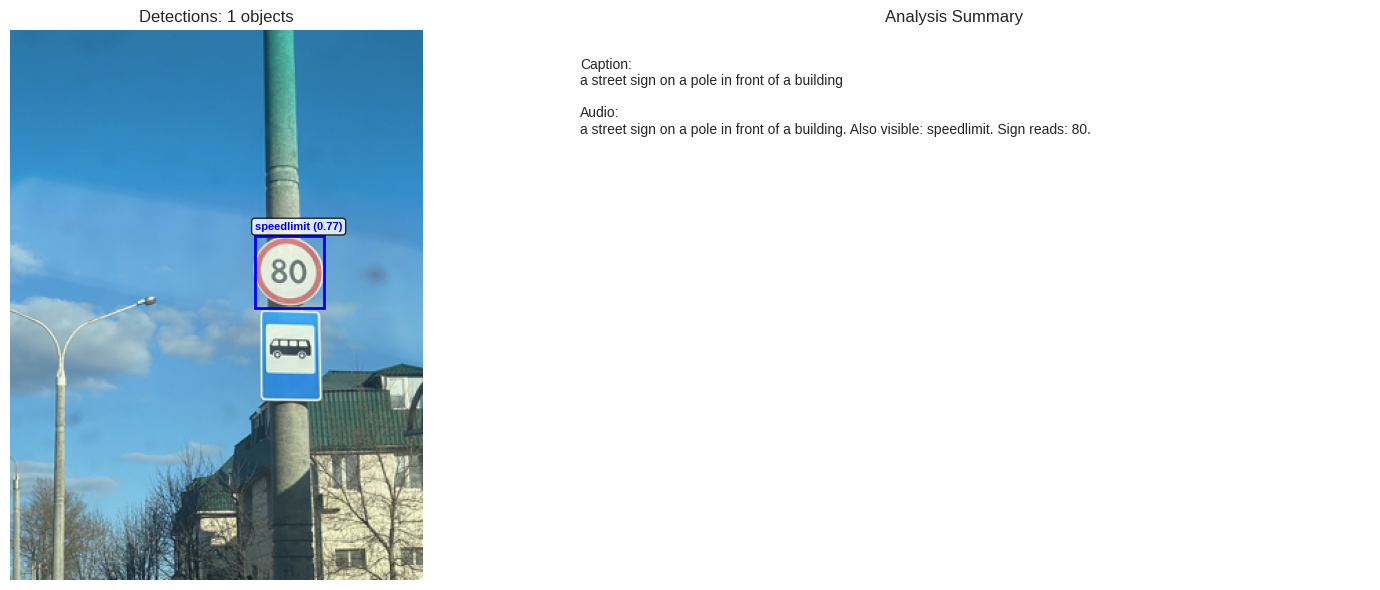

Audio saved: /kaggle/working/demo_audio_1.mp3

Audio output:



DEMO IMAGE 2: 000000170099.jpg

Analyzing: 000000170099.jpg
   Detected 2 objects
   Caption: a man wearing a red tie
   Audio: Attention: person very close on left. a man wearing a red tie. Also visible: couch.


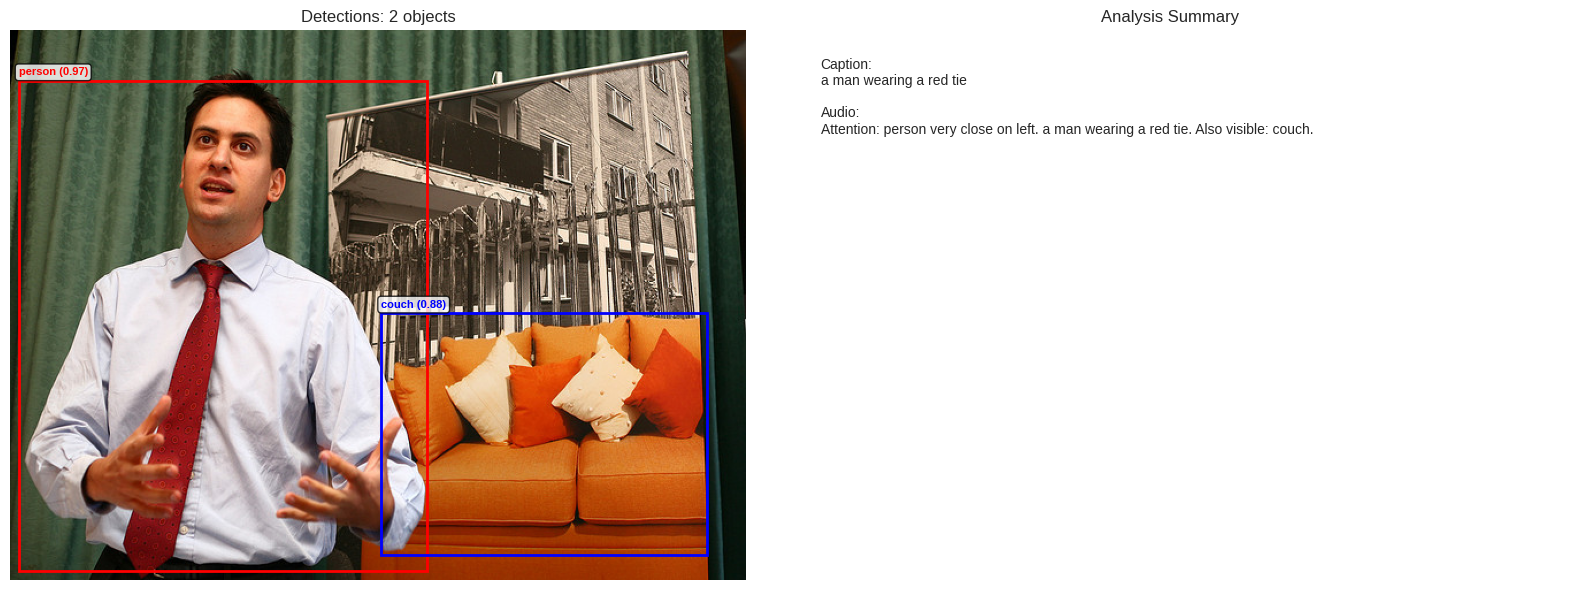

Audio saved: /kaggle/working/demo_audio_2.mp3

Audio output:



DEMO IMAGE 3: road45.png

Analyzing: road45.png
   Detected 11 objects
   Caption: a man riding a bike in the snow
   Audio: a man riding a bike in the snow.


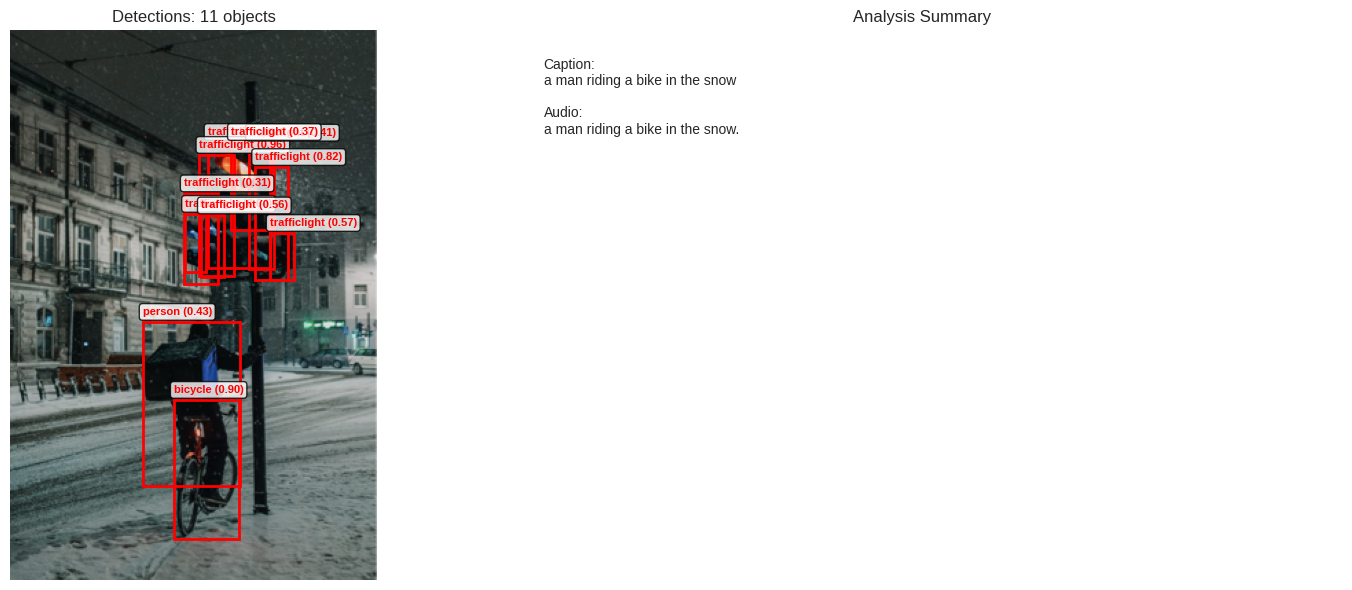

Audio saved: /kaggle/working/demo_audio_3.mp3

Audio output:



DEMO SUMMARY
Images processed: 3
Avg objects detected: 4.7
Avg priority objects: 4.0

Sample outputs:

[Image 1]
   Caption: a street sign on a pole in front of a building
   Audio: a street sign on a pole in front of a building. Also visible: speedlimit. Sign reads: 80....

[Image 2]
   Caption: a man wearing a red tie
   Audio: Attention: person very close on left. a man wearing a red tie. Also visible: couch....

[Image 3]
   Caption: a man riding a bike in the snow
   Audio: a man riding a bike in the snow....


In [ ]:
# Demo: System Output

print("=" * 60)
print("Demo: Complete System Output")
print("=" * 60)

demo_dir = os.path.join(YOLO_DIR, "images", "test")
if not os.path.exists(demo_dir) or not os.listdir(demo_dir):
    demo_dir = os.path.join(YOLO_DIR, "images", "val")

demo_images = [f for f in os.listdir(demo_dir) if f.endswith(('.jpg', '.png'))]

demo_results = []
for i, img_name in enumerate(demo_images[:3]):
    img_path = os.path.join(demo_dir, img_name)
    
    print(f"\n{'='*60}")
    print(f"Image {i+1}: {img_name}")
    print(f"{'='*60}")
    
    result = system.analyze(img_path, visualize=True)
    
    audio_file = f"demo_audio_{i+1}.mp3"
    audio_system.save_feedback(result['audio_description'], audio_file)
    audio_system.play_feedback(result['audio_description'])
    
    demo_results.append({
        'image': img_name,
        'objects': result['num_objects'],
        'priority': result['num_priority'],
        'caption': result['caption']
    })

print(f"\n{'='*60}")
print("Demo Summary")
print(f"{'='*60}")
print(f"Images: {len(demo_results)}")
print(f"Avg Objects: {np.mean([r['objects'] for r in demo_results]):.1f}")
print(f"Avg Priority Objects: {np.mean([r['priority'] for r in demo_results]):.1f}")

In [ ]:
# Project Summary

print("=" * 70)
print("Vision-Language-Audio Perception System - Complete")
print("=" * 70)

print("""
Summary
=======

Data Processing:
  - COCO 2014 filtered to assistive-relevant classes
  - Road Sign dataset integrated
  - Unified class mapping (28 classes)
  - Train/Val/Test split: 70/15/15

Model Training:
  - Architecture: YOLOv8s (fine-tuned)
  - Epochs: 100
  - Optimizer: AdamW
  - Data augmentation: Mosaic, MixUp, geometric transforms

Multi-Modal Pipeline:
  - Detection: YOLOv8 with NMS
  - OCR: TrOCR for text recognition
  - Captioning: BLIP-2 with hallucination reduction
  - Fusion: Structured scene understanding
  - Audio: gTTS real-time feedback

Artifacts:
  - yolo_assistive_vision.pt (trained model)
  - class_config.json (class mapping)
  - system_config.json (configuration)
  - training_results/ (curves and metrics)
""")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Pipeline complete.")
print("\nAuthor: Aayush Khanal")
print("Student ID: 20049123")

VISION-LANGUAGE-AUDIO PERCEPTION SYSTEM - COMPLETE

PROJECT COMPLETION SUMMARY

DATA PROCESSING:
  - COCO 2014 filtered to assistive-relevant classes
  - Road Sign dataset integrated
  - Unified class labels normalized (28 classes)
  - Train/Val/Test split (70/15/15)

MODEL TRAINING:
  - YOLOv8s fine-tuned on combined dataset
  - Data augmentation (brightness, noise, flip, mosaic, mixup)
  - Kaggle GPU optimized

MULTI-MODAL PIPELINE:
  - Detection: YOLOv8 with NMS post-processing
  - OCR: TrOCR for text-bearing regions
  - Captioning: BLIP-2 with hallucination reduction
  - Fusion: Structured scene understanding
  - Audio: gTTS real-time feedback

EVALUATION METRICS:
  - Detection: mAP@50, mAP@50-95, Precision, Recall, F1
  - Speed: Inference time, FPS
  - Pipeline: End-to-end latency

ARTIFACTS SAVED:
  - yolo_assistive_vision.pt
  - class_config.json
  - system_config.json
  - training_results/

USAGE:
  result = run_assistive_analysis("/path/to/image.jpg")
  # Returns: detections, 